In [1]:
from medmnist import PneumoniaMNIST
from medmnist import INFO
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import pennylane as qml
import torch
from pennylane import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
def load_data(batch_size=32, train_fraction=0.2, val_fraction=1.0, test_fraction=1.0):
    data_flag = 'pneumoniamnist'
    info = INFO[data_flag]
    transform = transforms.Compose([
        transforms.Resize((28,28)),
        # transforms.Resize((4,4)),
        transforms.ToTensor()
    ])

    # aug_transform = transforms.Compose([
    #     transforms.Resize((28, 28)),
    #     transforms.RandomHorizontalFlip(p=0.5),
    #     transforms.RandomRotation(degrees=10),
    #     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #     transforms.ToTensor()
    # ])
    
    # train_dataset = PneumoniaMNIST(split='train', transform=aug_transform, download=True)
    train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)


    if train_fraction < 1.0:
        n_train = int(len(train_dataset) * train_fraction)
        indices = np.random.choice(len(train_dataset), n_train, replace=False)
        train_dataset = Subset(train_dataset, indices)

    if val_fraction < 1.0:
        n_val = int(len(val_dataset) * val_fraction)
        indices = np.random.choice(len(val_dataset), n_val, replace=False)
        val_dataset = Subset(val_dataset, indices)

    if test_fraction < 1.0:
        n_test = int(len(test_dataset) * test_fraction)
        indices = np.random.choice(len(test_dataset), n_test, replace=False)
        test_dataset = Subset(test_dataset, indices)
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset

In [3]:
def extract_xy_from_loader(dataloader):
    x_all = []
    y_all = []

    for x_batch, y_batch in dataloader:
        x_all.append(x_batch.view(x_batch.size(0), -1))
        y_all.append(y_batch)

    x = torch.cat(x_all, dim=0)
    y = torch.cat(y_all, dim=0)

    return x, y

In [4]:
def sample_batch(dataloader, n_samples=8, device='cpu'):
    for x, y in dataloader:
        x = x.view(x.size(0), -1).to(device)
        y = y.to(device)

        if n_samples <= x.size(0):
            return x[:n_samples], y[:n_samples]
        else:
            raise ValueError(f"Batch size {x.size(0)} is smaller than requested {n_samples}")

In [5]:
def show_images_batch(x_batch, y_batch, n_cols=4):
    n_samples = x_batch.size(0)
    n_rows = (n_samples + n_cols -1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

    if x_batch.ndim == 2:
        x_batch = x_batch.view(n_samples, 1, 4, 1)

    axes = axes.flatten() if n_samples > 1 else [axes]

    for i in range(n_samples):
        image = x_batch[i].squeeze().cpu().numpy()
        label = y_batch[i].item()
        axes[i].imshow(image, cmap='gray', aspect="auto")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    for i in range(n_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=0.1)

In [7]:
from sklearn.decomposition import PCA

class PCAEncoder:
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.fitted = False

    def fit(self, dataloader):
        all_images = []
        for x, _ in dataloader:
            x = x.view(x.size(0), -1)
            all_images.append(x)
        X = torch.cat(all_images, dim=0).numpy()
        self.pca.fit(X)
        self.fitted = True

    # def transform(self, x):
    #     if not self.fitted:
    #         raise RuntimeError("PCAEncoder must be fit before calling transform.")
    #     x = x.view(x.size(0), -1).numpy()
    #     return torch.tensor(self.pca.transform(x), dtype=torch.float32)

    def transform(self, dataloader):
        if not self.fitted:
            raise RuntimeError("PCA Encoder mus be fit before calling transform.")

        all_transformed = []
        all_labels = []
        for x, y in dataloader:
            x = x.view(x.size(0), -1).numpy()
            x_transformed = self.pca.transform(x)
            all_transformed.append(torch.tensor(x_transformed, dtype=torch.float32))
            all_labels.append(y)

        x_all = torch.cat(all_transformed, dim=0)
        y_all = torch.cat(all_labels, dim=0)
        return x_all, y_all

        # return torch.cat(all_transformed, dim=0)

    # def fit_transform(self, dataloader):
    #     self.fit(dataloader)
    #     return self.transform(dataloader)

## TEST PCA DIMENSION REDUCTION (MODIFY ENCODER TRANSFORM AND FIT FUNC TO SEE RESULTS)

In [ ]:
# train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32)

# # encoder = PCAEncoder(n_components=4)
# encoder = PCAEncoder(n_components=0.65)
# encoder.fit(train_loader)

# x_batch, y_batch = sample_batch(train_loader, n_samples=8)

# x_encoded = encoder.transform(x_batch)

# print(x_encoded.shape)

In [ ]:
# print("Explained variance ratio", encoder.pca.explained_variance_ratio_)
# print("Shape of PCA components", encoder.pca.components_.shape)

In [ ]:
# # plt.plot(np.cumsum(encoder.pca.explained_variance_ratio_))
# plt.plot(np.arange(1, len(encoder.pca.explained_variance_ratio_) + 1),
#          np.cumsum(encoder.pca.explained_variance_ratio_))
# plt.xlabel('Number of components')
# plt.ylabel('Explained variance')
# plt.title('PCA Variance Explained')
# plt.grid()
# plt.show()

In [ ]:
# x_reconstructed = encoder.pca.inverse_transform(x_encoded)

# x_reconstructed = x_reconstructed.detach().clone().view(-1, 28, 28)

# plt.figure(figsize=(10, 4))
# for i in range(8):
#     plt.subplot(2, 4, i+1)
#     plt.imshow(x_reconstructed[i], cmap='gray')
#     plt.axis('off')

# plt.suptitle('reconstructed images after pca')
# plt.show()

## PCA DATA ENCODING

In [8]:
# encoder = PCAEncoder(n_components=0.65)
encoder = PCAEncoder(n_components=4)
# encoder = PCAEncoder(n_components=8)
encoder.fit(train_loader)

#transforming every set of data
x_train_encoded, y_train_tensor = encoder.transform(train_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_loader)

In [9]:
def visualize_umap(X, y, title="UMAP projection of PCA-reduced data"):
    # import umap.umap_ as umap
    import umap

    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.grid(True)
    plt.show()

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


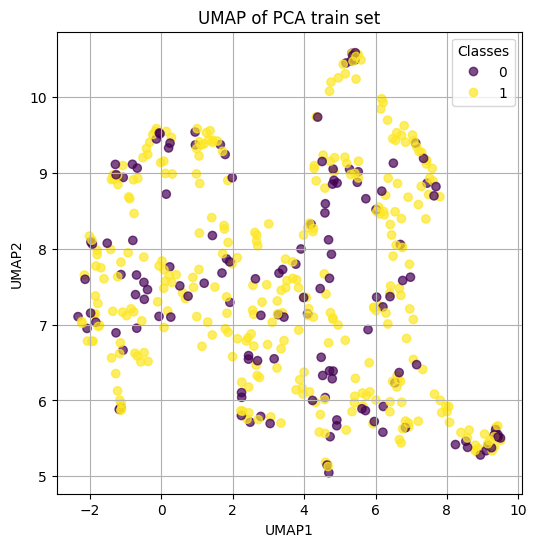

In [10]:
y_train = torch.cat([y for _, y in train_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy(), title="UMAP of PCA train set")

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


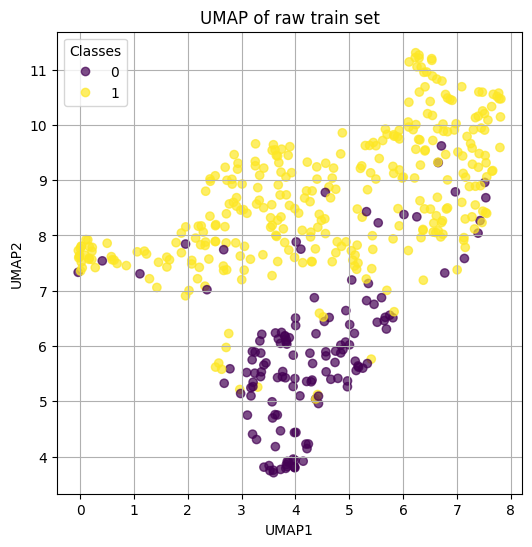

In [11]:
#original class separation
x_train_raw, y_train_raw = extract_xy_from_loader(train_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy(), title="UMAP of raw train set")

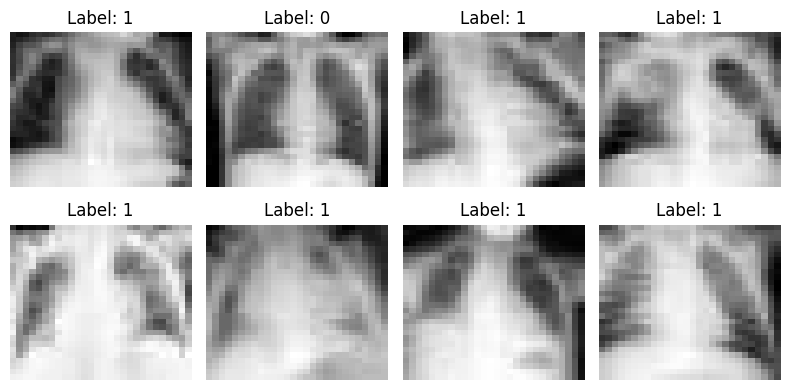

In [12]:
#original images
x_batch, y_batch = sample_batch(train_loader, n_samples=8)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_118908/1881510803.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


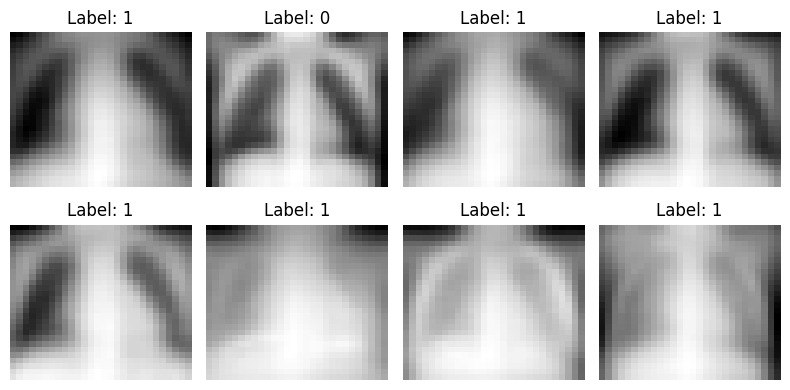

In [13]:
from torch.utils.data import TensorDataset

temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

# Step 3: Encode and decode using PCAEncoder
x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

# Step 4: Convert back to tensor and reshape to image dimensions
x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)
# x_reconstructed = x_reconstructed.detach().clone().requires_grad_(True)

# Step 5: Visualize reconstructed images
show_images_batch(x_reconstructed, y_batch)

In [14]:
print("train shape", x_train_encoded.shape)

train shape torch.Size([470, 4])


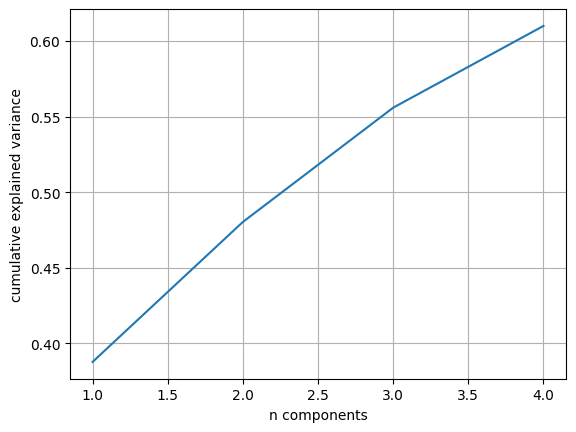

In [15]:
plt.plot(np.arange(1, len(encoder.pca.explained_variance_ratio_) + 1),
         np.cumsum(encoder.pca.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative explained variance")
plt.grid(True)
plt.show()

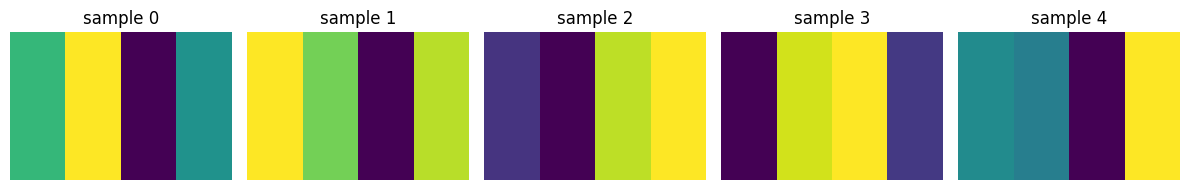

In [16]:
import seaborn as sns

plt.figure(figsize=(12, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.heatmap(x_train_encoded[i].unsqueeze(0), cmap='viridis', cbar=False)
    plt.title(f"sample {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
# n_qumodes = 6
n_qumodes = 4
cutoff_dim = 10
# cutoff_dim = 15
dev = qml.device("strawberryfields.fock", wires=n_qumodes, cutoff_dim=cutoff_dim)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def cv_qcnn_train(inputs, weights):
    for i in range(n_qumodes):
        qml.Displacement(inputs[i], 0.0, wires=i)
        qml.Squeezing(weights[0, i, 0], 0.0, wires=i)
        qml.Rotation(weights[0, i, 1], wires=i)

    for i in range(0, n_qumodes - 1, 2):
        qml.Beamsplitter(weights[0, i // 2, 2], weights[0, i // 2, 3], wires=[i, i+1])

    #optional deeper layer
    for i in range(n_qumodes):
        qml.Squeezing(weights[1, i, 0], 0.0, wires=i)
        qml.Rotation(weights[1, i, 1], wires=i)

    for i in range(1, n_qumodes - 1, 2):
        qml.Beamsplitter(weights[1, i // 2, 2], weights[1, i // 2, 3], wires=[i, i+1])

    # total_photons = sum(qml.NumberOperator(i) for i in range(n_qumodes))

    # return qml.expval(total_photons)

    # return sum(qml.expval(qml.NumberOperator(i) for i in range(n_qumodes)))

    return qml.expval(qml.NumberOperator(1))

    # return [qml.expval(qml.NumberOperator(i)) for i in range(n_qumodes)]

In [18]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def cv_qcnn(inputs, weights):
    for i in range(n_qumodes):
        qml.Displacement(inputs[i], 0.0, wires=i)
        qml.Squeezing(weights[0, i, 0], 0.0, wires=i)
        qml.Rotation(weights[0, i, 1], wires=i)

    for i in range(0, n_qumodes - 1, 2):
        qml.Beamsplitter(weights[0, i // 2, 2], weights[0, i // 2, 3], wires=[i, i+1])

    #optional deeper layer
    for i in range(n_qumodes):
        qml.Squeezing(weights[1, i, 0], 0.0, wires=i)
        qml.Rotation(weights[1, i, 1], wires=i)

    for i in range(1, n_qumodes - 1, 2):
        qml.Beamsplitter(weights[1, i // 2, 2], weights[1, i // 2, 3], wires=[i, i+1])
        
    return [qml.expval(qml.NumberOperator(i)) for i in range(n_qumodes)]

In [19]:

#dummy inputs: n_qumodes
dummy_inputs = torch.zeros(n_qumodes)
#dummy weights: number of layers, n_qumodes, n_input_features

dummy_weights = torch.zeros((2, n_qumodes, 6))

drawer = qml.draw(cv_qcnn)
print(drawer(dummy_inputs, dummy_weights))

0: ──D(0.00,0.00)──S(0.00,0.00)──R(0.00)─╭BS(0.00,0.00)──S(0.00,0.00)──R(0.00)────────────────┤  <n>
1: ──D(0.00,0.00)──S(0.00,0.00)──R(0.00)─╰BS(0.00,0.00)──S(0.00,0.00)──R(0.00)─╭BS(0.00,0.00)─┤  <n>
2: ──D(0.00,0.00)──S(0.00,0.00)──R(0.00)─╭BS(0.00,0.00)──S(0.00,0.00)──R(0.00)─╰BS(0.00,0.00)─┤  <n>
3: ──D(0.00,0.00)──S(0.00,0.00)──R(0.00)─╰BS(0.00,0.00)──S(0.00,0.00)──R(0.00)────────────────┤  <n>


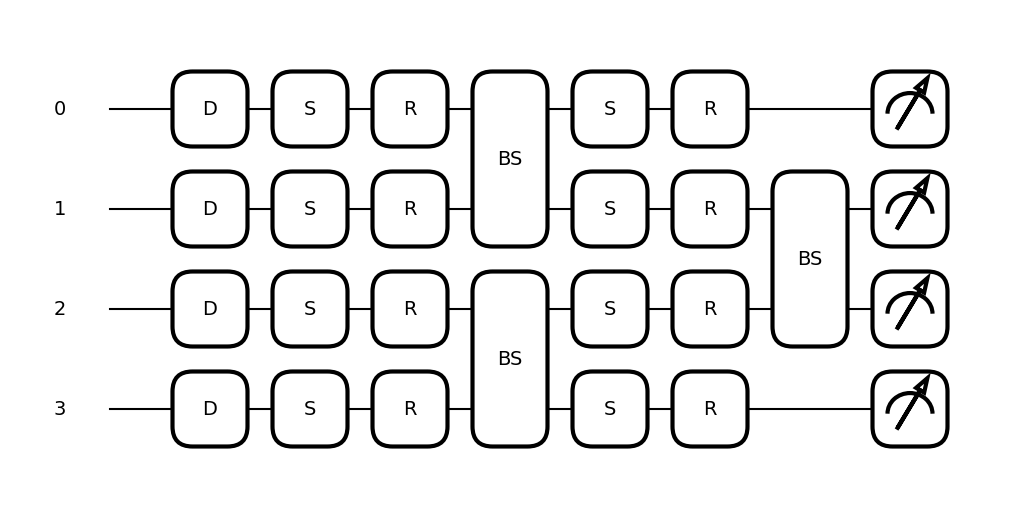

In [20]:
from pennylane import draw_mpl
fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights)
plt.show()

## QUANTUM PHOTONICS TESTS FOR PROPOSED QUANTUM CV CIRCUIT

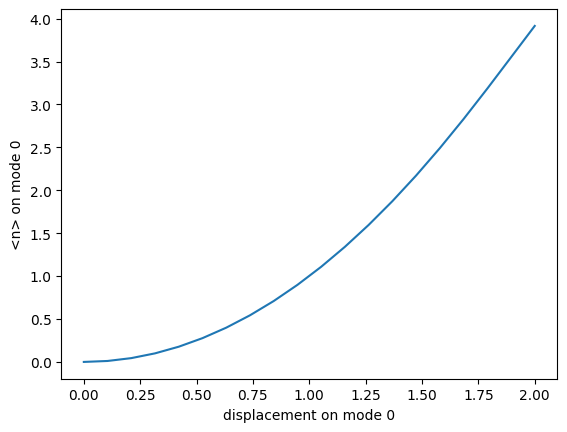

In [21]:
#single mode displacement test (displacement)
import numpy as np

displacements = np.linspace(0, 2, 20)
results = []

for d in displacements:
    inputs = np.zeros(n_qumodes)
    inputs[0] = d
    # result = cv_qcnn(inputs, torch.tensor(dummy_weights))
    result = cv_qcnn(inputs, dummy_weights.detach().clone())
    # results.append(result.detach().numpy())
    results.append(result.numpy() if isinstance(results, torch.Tensor) else result)

plt.plot(displacements, [r[0] for r in results])
plt.xlabel("displacement on mode 0")
plt.ylabel("<n> on mode 0")
plt.show()

In [22]:
#two-mode interference (beamsplitter)
inputs = np.zeros(n_qumodes)
inputs[0] = 1.0
result = cv_qcnn(inputs, dummy_weights.detach().clone())
print("<n> per mode:", result)

<n> per mode: tensor([1.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)


In [23]:
dummy_weights = torch.zeros((2, n_qumodes, 4))
dummy_weights[0, 0, 2] = np.pi/4 #theta for bs on wires [0, 1]
dummy_weights[0, 0, 3] = 0.0 #phi

In [24]:
inputs = np.zeros(n_qumodes)
inputs[0] = 1.0

result = cv_qcnn(inputs, dummy_weights)
print("<n> per mode:", result)

<n> per mode: tensor([0.5000, 0.5000, 0.0000, 0.0000], dtype=torch.float64)


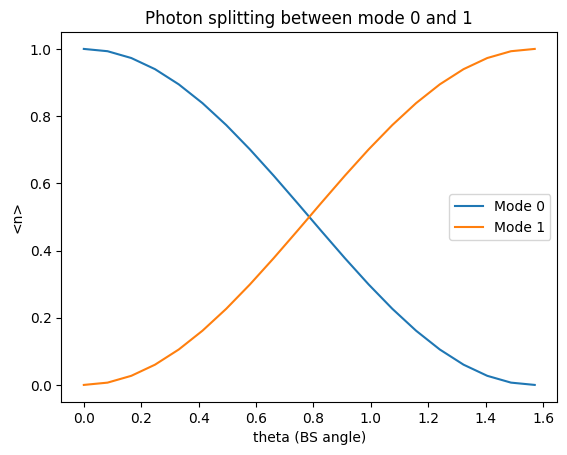

In [25]:
# sweeping theta from 0 to pi/2
thetas = np.linspace(0, np.pi/2, 20)
results = []

for t in thetas:
    dummy_weights = torch.zeros((2, n_qumodes, 4))
    dummy_weights[0, 0, 2] =  t
    inputs = np.zeros(n_qumodes)
    inputs[0] = 1.0
    result = cv_qcnn(inputs, dummy_weights)
    results.append([r.item() for r in result])

results = np.array(results)

plt.plot(thetas, results[:,0], label="Mode 0")
plt.plot(thetas, results[:, 1], label="Mode 1")
plt.xlabel("theta (BS angle)")
plt.ylabel("<n>")
plt.legend()
plt.title("Photon splitting between mode 0 and 1")
plt.show()

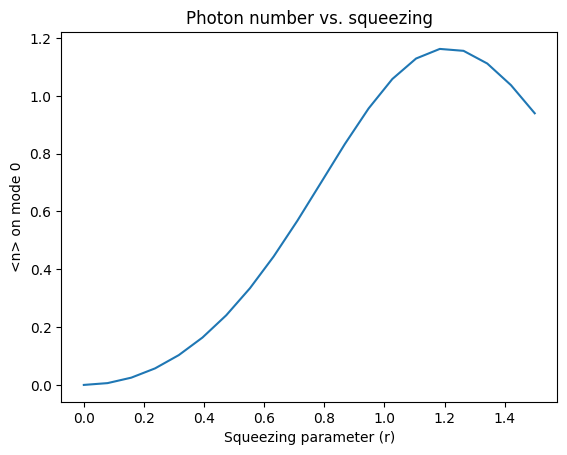

In [26]:
# squeezing behavior and how it amplifies quantum noise

squeezing_values = np.linspace(0, 1.5, 20)
outputs = []

for s in squeezing_values:
    weights = torch.zeros_like(dummy_weights)
    weights[0, :, 0] = s
    result = cv_qcnn(torch.zeros(n_qumodes), weights)
    # outputs.append(result.detach().numpy())
    outputs.append([r.detach().numpy() if isinstance(r, torch.Tensor) else r for r in result])

plt.plot(squeezing_values, [r[0] for r in outputs])
plt.xlabel("Squeezing parameter (r)")
plt.ylabel("<n> on mode 0")
plt.title("Photon number vs. squeezing")
plt.show()

In [27]:
# # gaussian input grid to test photon number output across two modes

# grid_size = 30
# x_vals = np.linspace(-2, 2, grid_size)
# y_vals = np.linspace(-2, 2, grid_size)

# results_mode0 = np.zeros((grid_size, grid_size))
# results_mode1 = np.zeros((grid_size, grid_size))

# for i, x in enumerate(x_vals):
#     for j, y in enumerate(y_vals):
#         inputs = np.zeros(n_qumodes)
#         inputs[0] = x
#         inputs[1] = y

#         result = cv_qcnn(inputs, dummy_weights.detach().clone())
#         result = result.numpy() if hasattr(result, "numpy") else result

#         results_mode0[j, i] = result[0]
#         results_mode1[j, i] = result[1]

# #heatmap mode 0
# plt.figure(figsize=(6, 5))
# plt.imshow(results_mode0, extent=(-2, 2, -2, 2), origin='lower', aspect='auto')
# plt.colorbar(label="<n> mode 0")
# plt.title("photon number in mode 0 <n> vs displacement grid")
# plt.xlabel("Displacement on mode 0")
# plt.ylabel("displacement on mode 1")
# plt.tight_layout()
# plt.show()
        

# #heatmap mode 1
# plt.figure(figsize=(6, 5))
# plt.imshow(results_mode1, extent=(-2, 2, -2, 2), origin='lower', aspect='auto')
# plt.colorbar(label="<n> mode 1")
# plt.title("photon number in mode 1 <n> vs displacement grid")
# plt.xlabel("Displacement on mode 0")
# plt.ylabel("displacement on mode 1")
# plt.tight_layout()
# plt.show()

In [28]:
#plotting wigner functions

def build_cv_qcnn(inputs, weights, up_to_layer=2):

    if up_to_layer >= 0:
        for i in range(n_qumodes):
            qml.Displacement(inputs[i], 0.0, wires=i)
            qml.Squeezing(weights[0, i, 0], 0.0, wires=i)
            qml.Rotation(weights[0, i, 1], wires=i)

    if up_to_layer >= 1:
        for i in range(0, n_qumodes -1, 2):
            qml.Beamsplitter(weights[0, i // 2, 2], weights[0, i // 2, 3], wires=[i, i+1])

    if up_to_layer >= 2:
        for i in range(n_qumodes):
            qml.Squeezing(weights[1, i, 0], 0.0, wires=i)
            qml.Rotation(weights[1, i, 1], wires=i)

    if up_to_layer >= 3:
        for i in range(1, n_qumodes - 1, 2):
            qml.Beamsplitter(weights[1, i // 2, 2], weights[1, i // 2, 3], wires=[i, i+1])

In [29]:
inputs = [0.5] * n_qumodes
weights = np.random.rand(2, n_qumodes, 4)

with qml.tape.QuantumTape() as tape:
    build_cv_qcnn(inputs, weights)

qml.execute([tape], dev, interface=None)
state = dev.state # this is a sf.backend fock backend

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/strawberryfields/program.py:732: UserWarning: The circuit consists of 2 disconnected components.


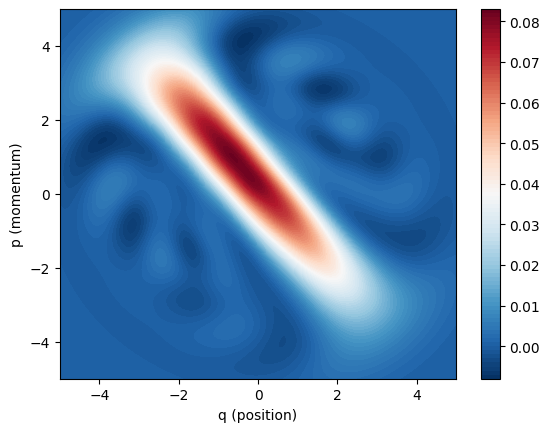

In [30]:
x = np.linspace(-5, 5, 200)

W = state.wigner(mode=0, xvec=x, pvec=x)

plt.contourf(x, x, W, 100, cmap="RdBu_r")
plt.xlabel("q (position)")
plt.ylabel("p (momentum)")
plt.colorbar()
plt.show()

In [31]:
# def plot_wigner_for_layers(inputs, weights, mode=0):
#     x = np.linspace(-5, 5, 200)

#     for up_to_layer in range(4):
#         with qml.tape.QuantumTape() as tape:
#             build_cv_qcnn(inputs, weights, up_to_layer=up_to_layer)
#         qml.execute([tape], dev, interface=None)
#         state = dev.state

#         w = state.wigner(mode=mode, xvec=x, pvec=x)
#         plt.figure(figsize=(5, 4))
#         plt.contourf(x, x, w, 100, cmap="RdBu_r")
#         plt.xlabel("q")
#         plt.ylabel("p")
#         plt.title(f"wigner - layer {up_to_layer}")
#         plt.colorbar()
#         plt.tight_layout()
#         plt.show()

In [32]:
# def plot_wigner_all_modes_per_layer(inputs, weights, dev, n_qumodes):
#     x = np.linspace(-5, 5, 200)

#     num_layers = 4
#     fig, axes = plt.subplots(num_layers, n_qumodes, figsize=(4 * n_qumodes, 4* num_layers))

#     # for up_to_layer in range(4):
#     for up_to_layer in range(num_layers):
#         with qml.tape.QuantumTape() as tape:
#             build_cv_qcnn(inputs, weights, up_to_layer=up_to_layer)
#         qml.execute([tape], dev, interface=None)
#         state = dev.state


#         for mode in range(n_qumodes):
#             wigner = state.wigner(mode=mode, xvec=x, pvec=x)
#             ax = axes[up_to_layer][mode] if n_qumodes > 1 else axes[up_to_layer]

#             cf = ax.contourf(x, x, wigner, 100, cmap="RdBu_r")
#             ax.set_title(f"Layer {up_to_layer} | Mode {mode}")
#             ax.set_xlabel("q")
#             ax.set_ylabel("p")

#     fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.6)
#     fig.tight_layout()
#     plt.show()

In [33]:
import matplotlib.gridspec as gridspec

def plot_wigner_all_layers(inputs, weights, n_qumodes, dev):
    x = np.linspace(-5, 5, 200)

    # fig = plt.figure(figsize=(14, 10))
    fig = plt.figure(figsize=(18, 12))
    outer = gridspec.GridSpec(4, n_qumodes, wspace=0.3, hspace=0.4)

    vmax = 0
    wigner_data_all = []

    for layer in range(4):
        with qml.tape.QuantumTape() as tape:
            build_cv_qcnn(inputs, weights, up_to_layer=layer)
        qml.execute([tape], dev, interface=None)
        state = dev.state

        layer_data = []
        for mode in range(n_qumodes):
            wigner = state.wigner(mode=mode, xvec=x, pvec=x)
            vmax = max(vmax, np.max(wigner))
            layer_data.append(wigner)
        wigner_data_all.append(layer_data)

    for i, layer_data in enumerate(wigner_data_all):
        for j, w in enumerate(layer_data):
            ax = plt.subplot(outer[i, j])
            im = ax.contourf(x, x, w, 100, cmap="RdBu_r", vmin=0, vmax=vmax)
            ax.set_xlabel("q")
            ax.set_ylabel("p")
            # ax.set_xticks([])
            # ax.set_yticks([])
            ax.set_title(f"Layer {i+1} | Mode {j+1}", fontsize=10)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/strawberryfields/program.py:732: UserWarning: The circuit consists of 4 disconnected components.
/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/strawberryfields/program.py:732: UserWarning: The circuit consists of 2 disconnected components.


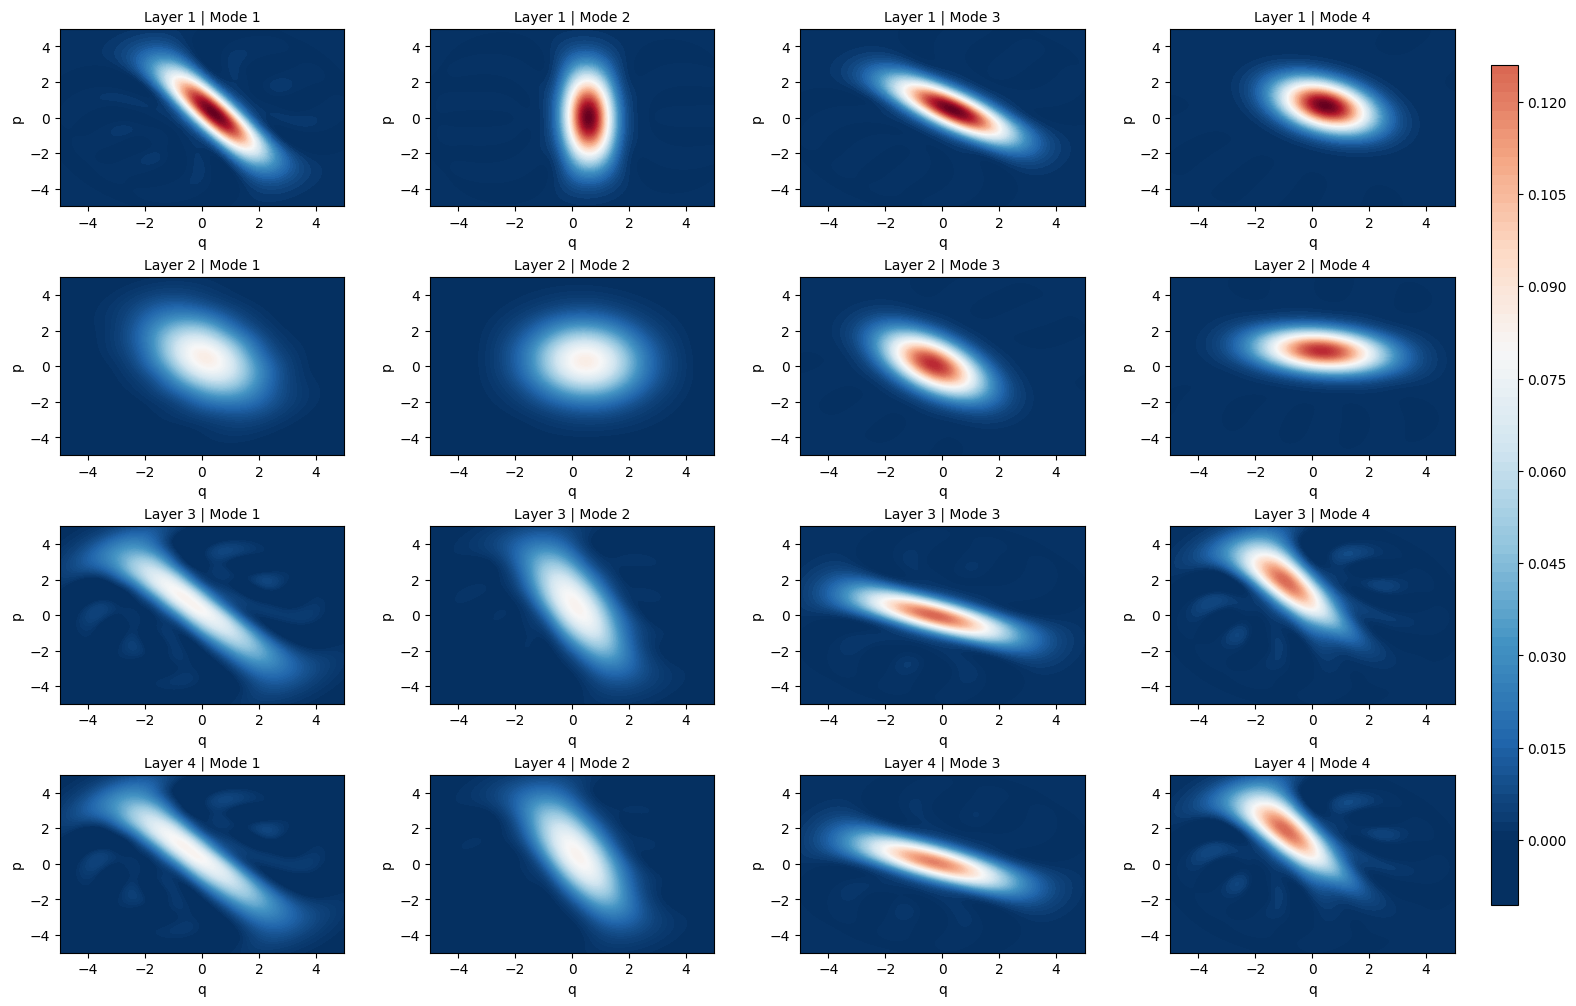

In [34]:
plot_wigner_all_layers(inputs, weights, n_qumodes, dev)

In [35]:
# from matplotlib.animation import FuncAnimation

# def animate_wigner_layers(inputs, weights, n_qumodes, dev, mode=0):
#     x = np.linspace(-5, 5, 200)
#     X, P = np.meshgrid(x, x)

#     wigner_data = []
#     for layer in range(4):
#         with qml.tape.QuantumTape() as tape:
#             build_cv_qcnn(inputs, weights, up_to_layer=layer)
#         qml.execute([tape], dev, interface=None)
#         state = dev.state
#         wigner = state.wigner(mode=mode, xvec=x, pvec=x)
#         wigner_data.append(wigner)

#     vmin = np.min(wigner_data)
#     vmax = np.max(wigner_data)

#     fig, ax = plt.subplots()
#     cont = ax.contourf(X, P, wigner_data[0], 100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
#     title = ax.set_title("Layer 0")


# def update(frame):
#     for c in cont.collections:
#         c.remove()
#     cont = ax.contourf(X, P, wigner_data[frame], 100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
#     title.set_text(f"Wigner function | Layer {frame}")
#     return cont.collections + [title]
    
#     anim = FuncAnimation(fig, update, frames=len(wigner_data), blit=True)
#     plt.xlabel("q")
#     plt.ylabel("p")
#     plt.colorbar(cont)
#     plt.tight_layout()
#     plt.show()

#     return anim

## DATA PREPARATION

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.fit_transform(x_val_encoded)
x_test_scaled = scaler.fit_transform(x_test_encoded)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [37]:
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)

In [38]:
print(x_train_tensor[0])

tensor([ 0.0804,  0.6230, -0.3809,  0.1981])


In [39]:
print(x_train_tensor[0].shape)

torch.Size([4])


In [40]:
# output = cv_qcnn(x_train_tensor[0], weights)
output = cv_qcnn_train(x_train_tensor[0], weights)

In [41]:
print(output)

tensor(0.8675, dtype=torch.float64)


In [42]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## TRAINING PREPARATION

In [43]:
# from pennylane.qnn import TorchLayer

# #model wrapper
# class QuantumWrapper(torch.nn.Module):
#     # def __init__(self, weights, n_qumodes, n_layers, n_classes=2, hidden_dim=16):
#     def __init__(self, n_qumodes, n_classes=2, hidden_dim=16):
#         super().__init__()

#         n_layers = 2
#         weight_shapes = {"weights": (n_layers, n_qumodes, 4)}
#         # quantum_layer = TorchLayer(qml.qnode(dev, interface="torch", diff_method="backprop")(cv_qcnn), weight_shapes)
#         quantum_layer = TorchLayer(qml.qnode(dev, interface="torch", diff_method="parameter-shift")(cv_qcnn), weight_shapes)

#         self.quantum = quantum_layer
#         self.n_qumodes = n_qumodes
#         self.n_classes = n_classes
#         self.hidden_dim = hidden_dim
        
#         self.head = nn.Sequential(
#             nn.Linear(1, self.hidden_dim),
#             nn.ReLU(),
#             nn.Linear(self.hidden_dim, self.n_classes)
#         )

#     def forward(self, x):
#         print("input shape: ", x.shape)
#         # out = torch.stack([self.quantum(sample) for sample in x], dim=0)
#         out = torch.stack([self.quantum(sample) for sample in x])
#         # out = self.quantum(x)

#         print("Quantum output shape: ", out.shape)
#         # out = out.view(x.shape[0], self.n_qumodes)
#         out = out.sum(dim=1).unsqueeze(1)
#         return self.head(out)

In [44]:
from pennylane.qnn import TorchLayer

class QuantumWrapper(torch.nn.Module):
    def __init__(self, n_qumodes, n_classes=2, hidden_dim=16):
        super().__init__()

        n_layers = 2
        weight_shapes = {"weights": (n_layers, n_qumodes, 4)}

        quantum_layer = TorchLayer(
            qml.qnode(dev, interface="torch", diff_method="parameter-shift")(cv_qcnn_train),
            # qml.qnode(dev, interface="torch", diff_method="parameter-shift")(cv_qcnn),
            weight_shapes
        )

        self.quantum = quantum_layer
        self.n_qumodes = n_qumodes
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim

        self.head = nn.Sequential(
            nn.Linear(1, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.n_classes)
        )

    def forward(self, x):
        print("input shape: ", x.shape)
        quantum_outs = self.quantum(x)
        print("quantum out shape: ", quantum_outs.shape)
        return self.head(quantum_outs.view(-1,1))

In [50]:
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        print(x_batch.device)
        
        optimizer.zero_grad()
        logits = model(x_batch)
        print(logits.shape)
        print(logits.device)
        # loss = loss_fn(logits, y_batch)
        loss = criterion(logits, y_batch.view(-1).long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{(correct/total_samples):.4f}"
        })


    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

In [51]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            # print(outputs.shape)
            loss = criterion(outputs, y_batch.view(-1).long())

            total_loss += loss.item() * x_batch.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_samples += x_batch.size(0)

        avg_loss = total_loss / total_samples
        avg_acc = total_correct / total_samples
        return avg_loss, avg_acc

In [52]:
epochs = 10
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumWrapper                           --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       32
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
Total params: 98
Trainable params: 98
Non-trainable params: 0

In [53]:
# for x_batch, y_batch in train_loader:
#     print(x_batch)
#     print(y_batch)
#     break

In [54]:
for epoch in range(epochs):
    print(f"epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(cv_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(cv_model, val_loader, criterion, device)

    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

epoch 1/10


Training:   0%|                                          | 0/15 [00:00<?, ?it/s]

cpu
input shape:  torch.Size([32, 4])
quantum out shape:  torch.Size([32])
torch.Size([32, 2])
cpu


KeyboardInterrupt: 

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracies", marker="o")
    plt.plot(epochs, val_accuracies, label="Validation Accuracies", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)    

    plt.tight_layout()
    plt.show()